# Local Regression of ranking

In [1]:
"""
This module implements the Lowess function for nonparametric regression.
Functions:
lowess Fit a smooth nonparametric regression curve to a scatterplot.
For more information, see
William S. Cleveland: "Robust locally weighted regression and smoothing
scatterplots", Journal of the American Statistical Association, December 1979,
volume 74, number 368, pp. 829-836.
William S. Cleveland and Susan J. Devlin: "Locally weighted regression: An
approach to regression analysis by local fitting", Journal of the American
Statistical Association, September 1988, volume 83, number 403, pp. 596-610.
"""

# Authors: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#
# License: BSD (3-clause)

from math import ceil
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg


def lowess(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
#             beta = linalg.solve(A, b)
            beta = linalg.lstsq(A, b)[0]
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest

if __name__ == '__main__':
    import math
    n = 100
    x = np.linspace(0, 2 * math.pi, n)
    y = np.sin(x) + 0.3 * np.random.randn(n)

    f = 0.25
    yest = lowess(x, y, f=f, iter=3)

    import pylab as pl
    pl.clf()
    pl.plot(x, y, label='y noisy')
    pl.plot(x, yest, label='y pred')
    pl.legend()
    pl.show()

<Figure size 640x480 with 1 Axes>

# Step 3: Evaluate weights and derived GRNs

In [2]:
%matplotlib inline

import pickle
import matplotlib.pyplot as plt
import numpy as np
import ipdb
import copy
import seaborn as sns
# plt.rcParams['figure.dpi'] = 150

In [3]:
p2saved_file = '/data/jianhao/hepatocyte_update_dataset_101619/new_results_with_monoc_NF_100'
num_target_genes = 1000
num_TFs = 200

with open(p2saved_file, 'rb') as f:
    results_all = pickle.load(f)
    
results_all.keys()

dict_keys(['weight_dic', 'adjusted_r_squared', 'standard_error', 'TF_ids', 'query_targets'])

In [4]:
weight_dic = results_all['weight_dic']
TF_ids = results_all['TF_ids']
target_ids = results_all['query_targets']
print('length of TF: ',len(TF_ids))

for label in weight_dic:
    print(weight_dic[label].shape)
    break

length of TF:  200
(201, 1000)


In [5]:
results_all['weight_dic'].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])

# sort by ranking

In [6]:
def array_to_rank(in_arr):
    '''
    The bigger the element, the higher rank (larger number in ranks list)
    '''
    np_arr = np.array(in_arr)
    tmp = (np_arr).argsort()
    ranks = np.empty_like(tmp)
    ranks[tmp] = np.arange(len(np_arr))
    return ranks

def sort_TF_by_ranking(weight_dic, TF_ids, top_k = 5):
    '''
    weight_dic: {label: weight_mat}
    weight_mat: num_TF * num_target
    '''
    len_of_TF = len(TF_ids)
    weight_dic_new = copy.deepcopy(weight_dic)
    for label in weight_dic_new:
        weight_mat = np.abs(weight_dic_new[label])
        for col_idx in range(weight_mat.shape[1]):
            w_vector = weight_mat[:len_of_TF, col_idx]
            ranks = array_to_rank(w_vector)
            weight_dic_new[label][:len_of_TF, col_idx] = ranks
    
    # drop the bias term in weight_mat.
    for label in weight_dic_new:
        weight_mat = weight_dic_new[label]
        weight_dic_new[label] = weight_mat[:len_of_TF, :]
    
    # sort TFs based on their average ranking
    TF_importance = {}
    fig = plt.figure(figsize = [6, 6], dpi = 150)
    for label in weight_dic_new:
        
        average_importance = weight_dic_new[label].mean(axis = 1)
        tmp = average_importance.argsort()
        tmp_idx = np.array(tmp[-top_k:])
        selected_idx = []
        for val in tmp_idx:
            if np.sort(abs(tmp_idx - val))[1] > 2 or True:
                selected_idx.append(val)
        # larger weights/rank will be the last k.
        topk_TF = [TF_ids[x] for x in tmp_idx]
        
        
        ax = fig.add_subplot(1, len(weight_dic_new), label)
        max_rank = np.max(np.max(weight_dic_new[label]))
#         im = ax.imshow(weight_dic_new[label] > max_rank - top_k)
        ax = sns.heatmap(weight_dic_new[label] > max_rank - top_k, cmap = ['grey', 'r'], cbar = False)
        ax.set_xlabel('target index', fontsize = 5)
#         ax.set_xticks(None)
#         ax.xaxis.set_ticks_position('none') 
#         ax.xaxis.set_ticks('none')
        ax.tick_params(axis='x', which='both', length=0, labelbottom=False)
#         ax.set_ylabel('TF ids')
        if label == 1:
            ax.set_yticks(selected_idx)
            ax.set_yticklabels(topk_TF, fontsize = 5)
        else:
            ax.tick_params(axis = 'both', which = 'both', length = 0, labelleft = False)
        ax.set_title('cluster label {}'.format(label), fontsize = 5)
        
        
        rank_TF = array_to_rank(average_importance)
        TF_importance[label] = {}
        TF_importance[label]['TF_average_importance'] = average_importance
        TF_importance[label]['TF_ranking'] = rank_TF
        TF_importance[label]['top k TFs'] = topk_TF
    plt.show()
    return TF_importance, weight_dic_new


In [7]:
test_arr = [5, 2, 4, 1]
test_rank = array_to_rank(test_arr)
print(test_rank)

[3 1 2 0]


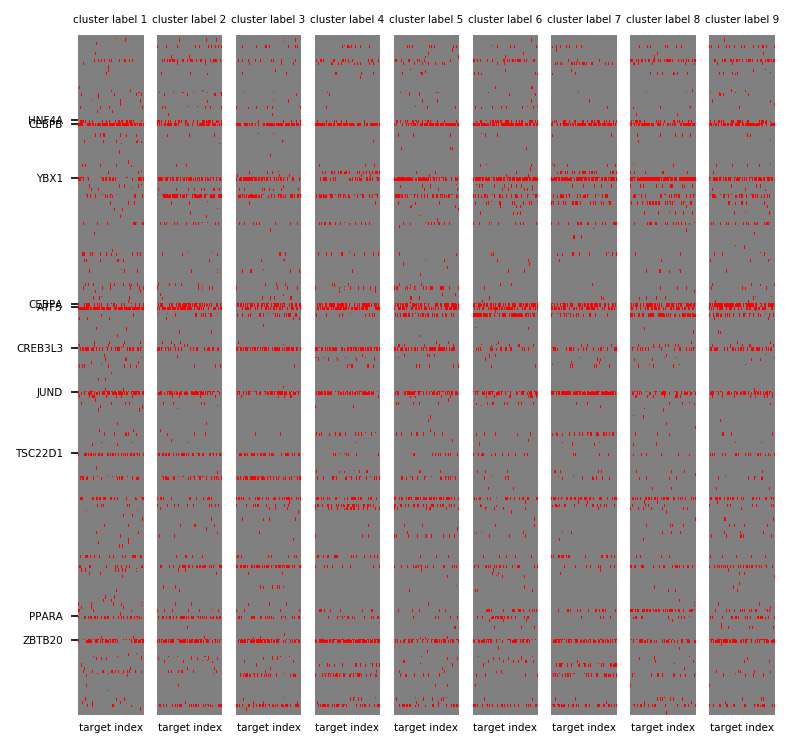

In [8]:
TF_ranking, weight_dic_ranking = sort_TF_by_ranking(weight_dic, TF_ids, 10)
# print(weight_dic_ranking)

In [9]:
len(weight_dic_ranking)

9

In [10]:
list_of_important_TF = []
for label in TF_ranking:
    print([label])
    print(TF_ranking[label]['top k TFs'])
    for tf in TF_ranking[label]['top k TFs']:
        list_of_important_TF.append(tf)

[1]
['CEBPA', 'YBX1', 'HNF4A', 'ZBTB20', 'TSC22D1', 'PPARA', 'CREB3L3', 'JUND', 'CEBPB', 'ATF5']
[2]
['CREB3L3', 'PPARA', 'HNF4A', 'CEBPA', 'JUND', 'YBX1', 'ID3', 'CEBPB', 'ATF5', 'ZBTB20']
[3]
['XBP1', 'TFDP2', 'ATF5', 'CEBPA', 'ID2', 'YBX1', 'CREB3L3', 'ZBTB20', 'JUND', 'CEBPB']
[4]
['NFIA', 'XBP1', 'SREBF1', 'YBX1', 'CREB3L3', 'JUND', 'CEBPA', 'ATF5', 'CEBPB', 'ZBTB20']
[5]
['DBP', 'ID3', 'ZBTB20', 'JUND', 'CREB3L3', 'XBP1', 'YBX1', 'ATF5', 'CEBPA', 'CEBPB']
[6]
['HNF4A', 'HHEX', 'XBP1', 'JUND', 'ATF5', 'DBP', 'ZBTB20', 'CEBPA', 'CEBPB', 'YBX1']
[7]
['ID3', 'HHEX', 'ATF5', 'CREB3L3', 'XBP1', 'CEBPA', 'ZBTB20', 'CEBPB', 'YBX1', 'JUND']
[8]
['ZBTB20', 'JUND', 'ID2', 'NR1I3', 'ATF5', 'PHF5A', 'DBP', 'CEBPA', 'CEBPB', 'YBX1']
[9]
['XBP1', 'CREB3L3', 'ID3', 'NR1I3', 'JUND', 'ATF5', 'YBX1', 'ZBTB20', 'CEBPB', 'CEBPA']


In [11]:
union_of_TFs = set(list_of_important_TF)
print(union_of_TFs)
index_of_union_TF = [TF_ids.index(tf) for tf in union_of_TFs]
print(index_of_union_TF)
print('- ' * 7) 
print([TF_ids[x] for x in index_of_union_TF])
print(len(union_of_TFs))

{'CEBPA', 'CREB3L3', 'HHEX', 'JUND', 'ATF5', 'PHF5A', 'SREBF1', 'DBP', 'XBP1', 'NFIA', 'ID2', 'HNF4A', 'NR1I3', 'TFDP2', 'CEBPB', 'ZBTB20', 'ID3', 'PPARA', 'YBX1', 'TSC22D1'}
[79, 92, 197, 105, 80, 169, 138, 82, 136, 40, 156, 25, 7, 130, 26, 178, 47, 171, 42, 123]
- - - - - - - 
['CEBPA', 'CREB3L3', 'HHEX', 'JUND', 'ATF5', 'PHF5A', 'SREBF1', 'DBP', 'XBP1', 'NFIA', 'ID2', 'HNF4A', 'NR1I3', 'TFDP2', 'CEBPB', 'ZBTB20', 'ID3', 'PPARA', 'YBX1', 'TSC22D1']
20


In [12]:
# TF_ranking.keys()

In [13]:
# TF_ranking[1].keys()

In [14]:
# print(TF_ranking[1]['top k TFs'])
# print(TF_ranking[1]['TF_average_importance'])
# print(TF_ranking[1]['TF_ranking'])

# Ranking of avarage importance

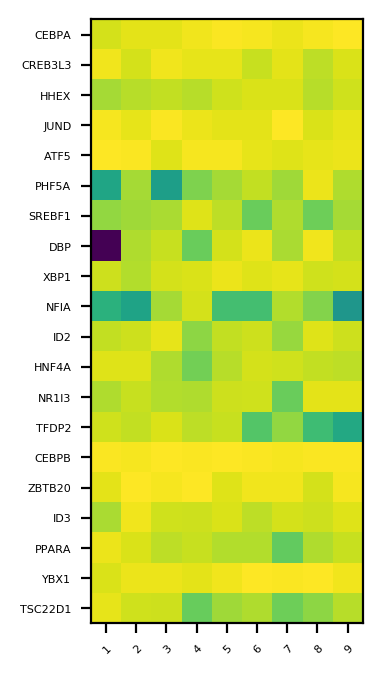

In [15]:
change_of_ranking_mat = np.empty((len(index_of_union_TF), len(TF_ranking)))
for label in TF_ranking:
    tmp = TF_ranking[label]['TF_ranking']
    union_TF = tmp[index_of_union_TF]
    change_of_ranking_mat[:, label - 1] = union_TF

fig, ax = plt.subplots(dpi = 200)
ax.imshow(change_of_ranking_mat)
ax.set_yticks(range(len(index_of_union_TF)))
ax.set_yticklabels([TF_ids[x] for x in index_of_union_TF], fontsize = 4)
ax.set_xticks(range(len(TF_ranking)))
ax.set_xticklabels([x + 1 for x in range(len(TF_ranking))], fontsize = 4)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
# fig=plt.figure(dpi = 500)
# plt.rcParams['figure.figsize'] = [20, 5]
# plt.rcParams.update({'font.size': 14})
plt.show()
    

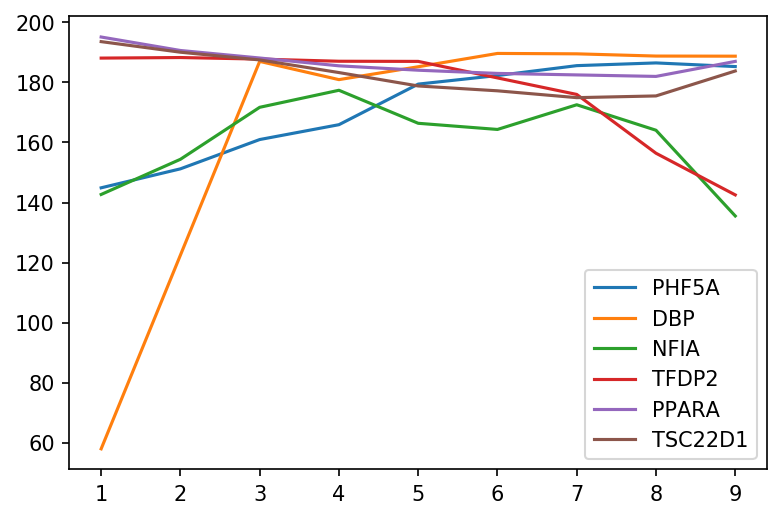

In [16]:
x = np.arange(1, len(weight_dic_ranking)+1)
y_var = change_of_ranking_mat.var(axis = 1)
y_var_threshold = np.quantile(y_var, q = 0.70)
# print(len(y_var))

plt.rcParams['figure.dpi'] = 150
for idx, row in enumerate(change_of_ranking_mat):
    f = 0.25
    if row.var() >= y_var_threshold:
        try:
            yest = lowess(x, row, f=f, iter=3)
            plt.plot(x, yest, label = TF_ids[index_of_union_TF[idx]])  
        except:
            continue

plt.legend()
# fig=plt.figure(dpi = 500)
plt.show()

# Average Ranking, raw value of [average of ranking in each target]

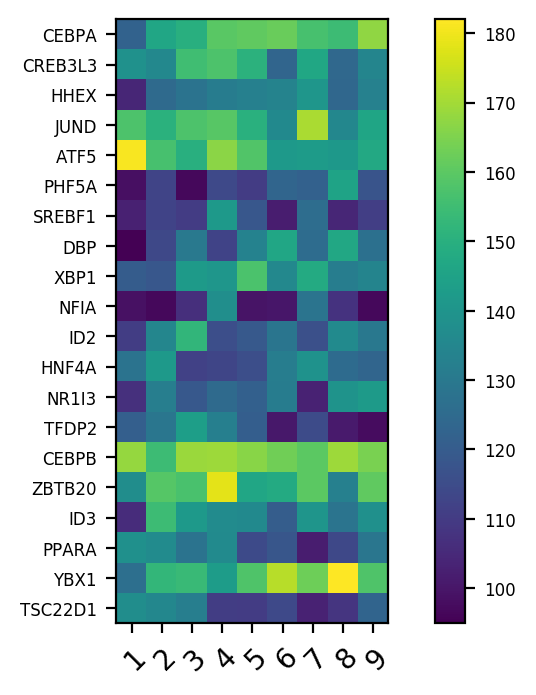

In [17]:
change_of_ranking_mat = np.empty((len(index_of_union_TF), len(TF_ranking)))
for label in TF_ranking:
    tmp = TF_ranking[label]['TF_average_importance']
    union_TF = tmp[index_of_union_TF]
    change_of_ranking_mat[:, label - 1] = union_TF

fig, ax = plt.subplots(dpi = 200)
tmp = ax.imshow(change_of_ranking_mat)
cb = plt.colorbar(tmp)
cb.ax.tick_params(labelsize=6) 
ax.set_yticks(range(len(index_of_union_TF)))
ax.set_yticklabels([TF_ids[x] for x in index_of_union_TF], fontsize = 6)
ax.set_xticks(range(len(TF_ranking)))
ax.set_xticklabels(x + 1 for x in range(len(TF_ranking)))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()

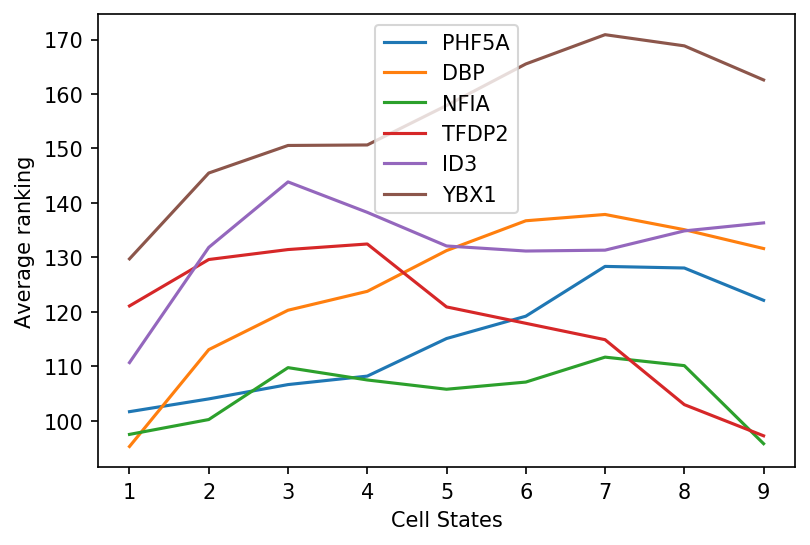

In [18]:
x = np.arange(1, (len(weight_dic_ranking))+1)
y_var = change_of_ranking_mat.var(axis = 1)
y_var_threshold = np.quantile(y_var, q = 0.70)
# print(len(y_var))

plt.rcParams['figure.dpi'] = 150
for idx, row in enumerate(change_of_ranking_mat):
    f = 0.25
    if row.var() >= y_var_threshold:
        try:
            yest = lowess(x, row, f=f, iter=3)
            plt.plot(x, yest, label = TF_ids[index_of_union_TF[idx]])    
        except:
            continue

plt.legend()
# fig=plt.figure(dpi = 500)
plt.xlabel('Cell States')
plt.ylabel('Average ranking')
plt.show()

In [19]:
weight_dic_ranking.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])

# plot changes of TF ranking in color.

In [ ]:
import seaborn as sns; sns.set()
top_k = 20

for label in range(1, len(weight_dic_ranking)):
    fig = plt.figure()
    tmp = weight_dic_ranking[label]
    max_rank = np.max(np.max(weight_dic_ranking[label]))
    bin_mat_prev = (weight_dic_ranking[label] > max_rank - top_k).astype(int)
    bin_mat_next = (weight_dic_ranking[label + 1] > max_rank - top_k).astype(int)
    
    # 'grey': 00, both inactive
    # 'g': 01, inactive to active
    # 'b': 10, active to inactive
    # 'r': both inactive
    color_map = bin_mat_next + bin_mat_prev * 2
    
    ascend_order = np.argsort(np.sum(color_map == 2, axis = 1))
#     selected_order = ascend_order[-5:]
#     selected_tf_ids = [TF_ids[x] for x in selected_order]
    
    tmp_idx = np.array(ascend_order[-top_k:])
    selected_idx = []
    for val in tmp_idx:
        if np.sort(abs(tmp_idx - val))[1] > 4:
            selected_idx.append(val)
    # larger weights/rank will be the last k.
    selected_order = selected_idx
    selected_tf_ids = [TF_ids[x] for x in selected_idx]
    
    ax = fig.add_subplot(1, len(weight_dic_ranking) - 1, label)
    ax = sns.heatmap(color_map, vmin=0, vmax=4, cmap = ['grey', 'g', 'b', 'r'])
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0.5, 1.5, 2.5, 3.5])
    cbar.set_ticklabels(['both inactive', 'inactive to active', 'active to inactive', 'both acitve'])
    ax.tick_params('both', labelbottom = False, length = 0)
    ax.set_title('label {} to label {}'.format(label, label + 1))
    ax.set_yticks(selected_order)
    ax.set_yticklabels(selected_tf_ids, fontsize = 8)
    plt.show()
#     break